# Part I - (Dataset Exploration Title)
## by Charles Nikoro

## Introduction

In this document, I will analyze loan data from Prosper (a peear-to-peer lending marketplace) comprising approximately 114000 records with the aim of investigating the possible factors that can affect the outcome of a loan's status.

> Introduce the dataset

>**Rubric Tip**: Your code should not generate any errors, and should use functions, loops where possible to reduce repetitive code. Prefer to use functions to reuse code statements.

> **Rubric Tip**: Document your approach and findings in markdown cells. Use comments and docstrings in code cells to document the code functionality.

>**Rubric Tip**: Markup cells should have headers and text that organize your thoughts, findings, and what you plan on investigating next.  



## Preliminary Wrangling


In [ ]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import math

%matplotlib inline

> Load in your dataset and describe its properties through the questions below. Try and motivate your exploration goals through this section.


In [291]:
# load data and check the first five records
# make sure the dates are correctly parsed

loans = pd.read_csv('../dataset/prosperLoanData.csv', parse_dates=['ListingCreationDate',
    'LoanOriginationDate', 'ClosedDate', 'DateCreditPulled'])

loans.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263,C,36,Completed,2009-08-14,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900,NaN,36,Current,NaT,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090,HR,36,Completed,2009-12-17,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010,NaN,36,Current,NaT,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097,NaN,36,Current,NaT,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


In [ ]:
# check the size of the dataset and whether it contains duplicate listings.

print("Shape of the dataframe:", loans.shape)
print("Number of duplicate records:", loans.duplicated().sum())

In [ ]:
# columns and their data types

dtypes = ['bool', 'int64', 'float64', 'object']

for dtype in dtypes:
    print(f"{dtype}\n{set(loans.dtypes[loans.dtypes == dtype].index)}\n")

In [292]:
# make ListingCategory (numeric), ProsperScore and Term of categorical types

def create_category_type(categories, ordered=False):
    """
        Create category type from the list of categories

        Args:
           list: the list of categories
           bool: whether the category type should be ordered. This is False by default

        Returns:
           a pandas CategoricalDtype object.
    """
    return pd.api.types.CategoricalDtype(categories=categories, ordered=ordered)

loans['ListingCategory (numeric)'] = loans['ListingCategory (numeric)'].astype(
    create_category_type(range(21))
)

loans.Term = loans.Term.astype(create_category_type([12,36,60], ordered=True))

# ProsperScore is an ordinal variable

loans.ProsperScore = loans.ProsperScore.astype(create_category_type(categories=range(1,12), ordered=True))

In [ ]:
# value counts of IncomeRange

print('Value counts of IncomeRange: \n',loans.IncomeRange.value_counts(dropna=False))
print()
print('Value counts of EmploymentStatus: \n', loans.EmploymentStatus.value_counts(dropna=False))

There are about 2255 records with a missing EmploymentStatus. Let's explore their Income ranges and compair them with those of borrowers with a "Not available" employment status.

In [ ]:
# Income range of borrowers with missing employment status

print('Income range of borrowers with missing employment status\n',
    loans[loans.EmploymentStatus.isna()][["IncomeRange"]].value_counts()
)

print()

# Income range of borrowers with a "Not available" employment status
print('Income range of borrowers with a "Not available" employment status',
      loans[loans.EmploymentStatus == "Not available"][['IncomeRange']].value_counts()
)

Both have a "Not displayed" income range. Therefore, we can safely assume that these missing records don't have available employment status. So, we would replace them with "Not available".

In [293]:
# replacing missing Employment status records with "Not available"

loans.EmploymentStatus.fillna("Not available", inplace=True)

loans.EmploymentStatus.value_counts(dropna=False)

Employed         67322
Full-time        26355
Not available     7602
Self-employed     6134
Other             3806
Part-time         1088
Not employed       835
Retired            795
Name: EmploymentStatus, dtype: int64

We will also merge the records of borrowers with a "Full-time" and "Part-time" employment status to those with an "Employed" status since we can assume that people with a full-time or part-time job are employed by some employer.

In [294]:
values_to_replace = ['Full-time', 'Part-time']
for value in values_to_replace:
    loans.EmploymentStatus.replace(value, "Employed", inplace=True)

loans.EmploymentStatus.value_counts()

Employed         94765
Not available     7602
Self-employed     6134
Other             3806
Not employed       835
Retired            795
Name: EmploymentStatus, dtype: int64

It is also not logical to have "Not employed" in the possible income range. Let's do a value count of their stated monthly income.

In [295]:
loans[loans.IncomeRange == "Not employed"].StatedMonthlyIncome.value_counts(dropna=False)

0.000000        726
0.083333         22
583.333333        2
833.333333        2
1000.000000       2
1250.000000       1
4000.000000       1
964.333333        1
839.666667        1
393.416667        1
860.000000        1
1400.000000       1
1500.000000       1
480.000000        1
20833.333333      1
2348.000000       1
57.583333         1
669.000000        1
1507.000000       1
430.000000        1
738.166667        1
6666.666667       1
875.000000        1
1916.666667       1
9096.000000       1
1173.000000       1
3000.000000       1
4166.666667       1
1409.250000       1
2972.000000       1
643.000000        1
5833.333333       1
1014.000000       1
856.000000        1
1211.666667       1
623.000000        1
2926.000000       1
1505.000000       1
175.000000        1
3500.000000       1
3633.000000       1
2167.583333       1
125.250000        1
1820.000000       1
1360.000000       1
2025.000000       1
828.000000        1
37.500000         1
3333.333333       1
2775.916667       1


From the counts, we can't assume that the true income range value of every borrower with a "Not employed" income range will be $0. Since the income range isn't displayed, it will be safe to merge these records with those whose income range isn't displayed.

In [296]:
loans.IncomeRange.replace("Not employed", "Not displayed", inplace=True)

loans.IncomeRange.value_counts(dropna=False)

$25,000-49,999    32192
$50,000-74,999    31050
$100,000+         17337
$75,000-99,999    16916
Not displayed      8547
$1-24,999          7274
$0                  621
Name: IncomeRange, dtype: int64

Let's make `IncomeRange` and `EmploymentStatus` categorical variables.

In [297]:
# IncomeRange should be categorical

categories = ['$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999',
               '$75,000-99,999', '$100,000+', 'Not displayed']

loans.IncomeRange = loans.IncomeRange.astype(create_category_type(categories=categories, ordered=True))

# EmploymentStatus should also be categorical

categories = ['Not employed', 'Self-employed', 'Employed', 'Retired', 'Other', 'Not available']
loans.EmploymentStatus = loans.EmploymentStatus.astype(create_category_type(categories=categories))

It also makes sense to make `LoanStatus` a categorical variable.

In [298]:
# check values of LoanStatus

loans.LoanStatus.value_counts()

Current                   56576
Completed                 38074
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Past Due (>120 days)         16
Cancelled                     5
Name: LoanStatus, dtype: int64

However, we won't be analyzing current and cancelled loans. Therefore, we will only be concerned with records that don't have these statuses.

In [300]:
# We won't consider current and cancelled loans in our analysis.

excluded_list = ['Current', 'Cancelled']

loan_sub_data = loans.query('LoanStatus not in @excluded_list').copy()

# the loan status should be categorical. We will also make it ordinal

categories = ['Completed', 'FinalPaymentInProgress',
 'Past Due (1-15 days)', 'Past Due (16-30 days)', 'Past Due (31-60 days)', 
'Past Due (61-90 days)', 'Past Due (91-120 days)', 'Past Due (>120 days)', 
'Defaulted', 'Chargedoff']

loan_sub_data.LoanStatus = loan_sub_data.LoanStatus.astype(create_category_type(categories=categories, ordered=True))

# The shape of the subset of data we will be analyzing

print(loan_sub_data.shape)

(57356, 81)


In [301]:
# columns without null values

columns_without_null = loan_sub_data.isna().sum()==0
loan_sub_data.isna().sum()[columns_without_null].index

Index(['ListingKey', 'ListingNumber', 'ListingCreationDate', 'Term',
       'LoanStatus', 'BorrowerRate', 'LenderYield',
       'ListingCategory (numeric)', 'EmploymentStatus', 'IsBorrowerHomeowner',
       'CurrentlyInGroup', 'DateCreditPulled', 'OpenRevolvingAccounts',
       'OpenRevolvingMonthlyPayment', 'IncomeRange', 'IncomeVerifiable',
       'StatedMonthlyIncome', 'LoanKey', 'LoanCurrentDaysDelinquent',
       'LoanMonthsSinceOrigination', 'LoanNumber', 'LoanOriginalAmount',
       'LoanOriginationDate', 'LoanOriginationQuarter', 'MemberKey',
       'MonthlyLoanPayment', 'LP_CustomerPayments',
       'LP_CustomerPrincipalPayments', 'LP_InterestandFees', 'LP_ServiceFees',
       'LP_CollectionFees', 'LP_GrossPrincipalLoss', 'LP_NetPrincipalLoss',
       'LP_NonPrincipalRecoverypayments', 'PercentFunded', 'Recommendations',
       'InvestmentFromFriendsCount', 'InvestmentFromFriendsAmount',
       'Investors'],
      dtype='object')

In [302]:
# columns with null values

columns_with_null = loan_sub_data.isna().sum()>0
loan_sub_data.isna().sum()[columns_with_null].index

Index(['CreditGrade', 'ClosedDate', 'BorrowerAPR', 'EstimatedEffectiveYield',
       'EstimatedLoss', 'EstimatedReturn', 'ProsperRating (numeric)',
       'ProsperRating (Alpha)', 'ProsperScore', 'BorrowerState', 'Occupation',
       'EmploymentStatusDuration', 'GroupKey', 'CreditScoreRangeLower',
       'CreditScoreRangeUpper', 'FirstRecordedCreditLine',
       'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years',
       'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies',
       'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'AvailableBankcardCredit', 'TotalTrades',
       'TradesNeverDelinquent (percentage)', 'TradesOpenedLast6Months',
       'DebtToIncomeRatio', 'TotalProsperLoans', 'TotalProsperPaymentsBilled',
       'OnTimeProsperPayments', 'ProsperPaymentsLessThanOneMonthLate',
       'ProsperPaymentsOneMonthPlusLate', 'Pro

### What is the structure of your dataset?
The dataset comprises 113937 observations and 81 variables which comprises both qualitative and quantitative variables. Some of them contain null values which means that there are no existing records for the borrower concerned. For instance, according to the [data dictionary](https://docs.google.com/spreadsheets/d/1gDyi_L4UvIrLTEC6Wri5nbaMmkGmLQBk-Yx3z0XDEtI/edit#gid=0), a borrower with a null `TotalProsperLoans` value doesn't have prior loans. The categorical variables includes `ListingCategory (numeric)`, `LoanStatus`, `IncomeRange`, `ProsperScore`, and `Term`. `ListingCategory (numeric)` is encoded as follows: 0 - Not Available, 1 - Debt Consolidation, 2 - Home 
Improvement, 3 - Business, 4 - Personal Loan, 5 - Student Use, 6 - Auto, 7- Other, 8 - Baby&Adoption, 9 - Boat, 10 - Cosmetic 
Procedure, 11 - Engagement Ring, 12 - Green Loans, 13 - Household Expenses, 14 - Large Purchases, 15 - Medical/Dental, 16 - 
Motorcycle, 17 - RV, 18 - Taxes, 19 - Vacation, 20 - Wedding Loans. `ProsperScore` include values from 1 to 11 with decreasing levels of risk.

### What is/are the main feature(s) of interest in your dataset?

I want to investigate the factors that could affect the outcome of a loan. In particular, I will be considering those that affect complete, default and charged-off loans. Therefore, I won't be considering current or cancelled loans in this analysis. 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

The original loan amount (`LoanOriginalAmount`) and the principal payments (`LP_CustomerPrincipalPayments`) made by the borrowers are interesting variables to consider. Other variables we would be considering includes: the annual percentage rates (`BorrowerAPR`), interests and fees paid by borrowers (`LP_InterestandFees`), term of the loan (`Term`), number of days the borrower was delinquent on the loan (`LoanCurrentDaysDelinquent`), income range (`IncomeRange`), employment status (`EmploymentStatus`), listing category (`ListingCategory (numeric)`), and total number of prior prosper loans (`TotalProsperLoans`).

## Univariate Exploration

I'll begin by looking at the distribution of the main variable of interest – `LoanStatus`.

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.


> **Rubric Tip**: The project (Parts I alone) should have at least 15 visualizations distributed over univariate, bivariate, and multivariate plots to explore many relationships in the data set.  Use reasoning to justify the flow of the exploration.



>**Rubric Tip**: Use the "Question-Visualization-Observations" framework  throughout the exploration. This framework involves **asking a question from the data, creating a visualization to find answers, and then recording observations after each visualisation.** 

##### Which loan status has the highest frequency count?

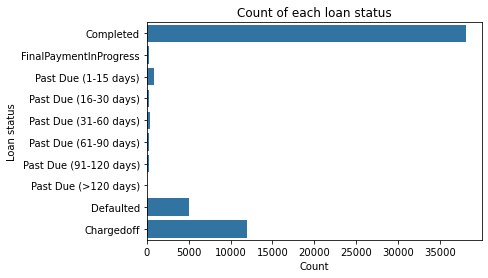

In [303]:
# plot distribution of LoanStatus

sns.countplot(data=loan_sub_data, y='LoanStatus', color=sns.color_palette()[0])
plt.xlabel('Count')
plt.ylabel('Loan status')
plt.title('Count of each loan status')
plt.show();

The above plot shows that most borrowers completed their loans while the least of them are more than 120 days passed due. 

##### What are the distributions of the income range and employment status?

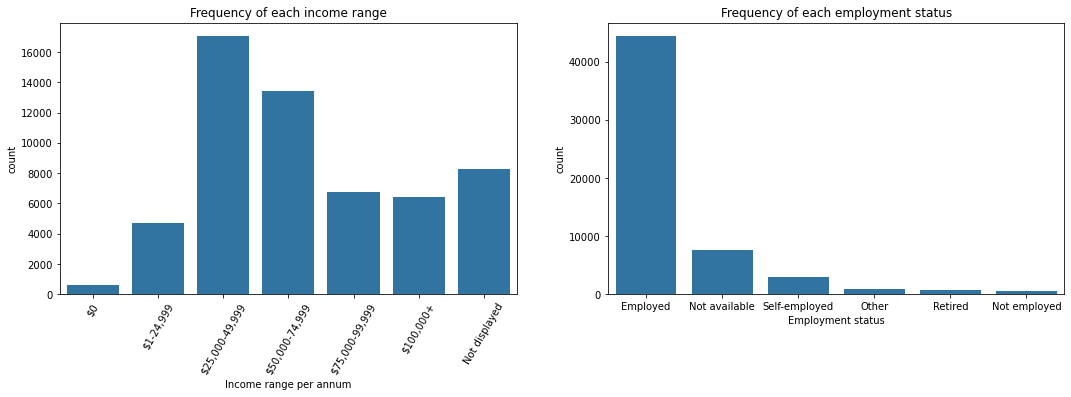

In [304]:
fig,axs = plt.subplots(1,2,figsize=(18,5))

# distribution of income range

ax1 = sns.countplot(data=loan_sub_data, x='IncomeRange', color=sns.color_palette()[0],
                    ax=axs[0])
ax1.set(xlabel='Income range per annum',
        title='Frequency of each income range')
ax1.set_xticklabels(labels=ax1.get_xticklabels(), rotation=60)

# distribution of employment status

ax2 = sns.countplot(data=loan_sub_data, x='EmploymentStatus', color=sns.color_palette()[0], 
        order=loan_sub_data.EmploymentStatus.value_counts().index, ax=axs[1])
ax2.set(xlabel="Employment status",
        title="Frequency of each employment status")

plt.show();


From the plots, most borrowers stated that have an annual income that falls in the range of $25,000 to $49,999. A very few had $0 annual income. Also, most borrowers are employed with a very stated as unemployed. The employment status of a considerable number of borrowers is not available.

##### What are the distributions of the original loan amount, and the amount of principal as well as interests and fees paid by the borrowers?

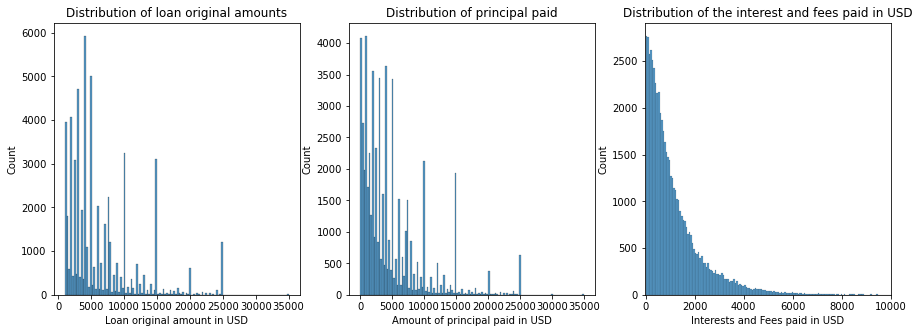

In [305]:
def get_bin_counts(series):
    """
       computes number of bins needed to plot the histogram of series
       using Freedman Diaconis algorithm if the IQR is not 0 else
       take the square root of the number of data points rounded up
       to the nearest integer
       
       :param series: quantitative pandas series
       :return integer: the number of bins
    """
    if series.quantile(0.75) - series.quantile(0.25) != 0:
        bin_width = 2*((series.quantile(0.75)-series.quantile(0.25))/(np.power(series.shape[0],1/3)))
        return ((series.max()-series.min())//bin_width).astype(int)
    return int(math.ceil(math.sqrt(series.shape[0])))

# distribution of the original loan amount

fig, axes = plt.subplots(1,3, figsize=(15,5))

ax1 = sns.histplot(data=loan_sub_data, x='LoanOriginalAmount', 
                  bins=get_bin_counts(loan_sub_data.LoanOriginalAmount), ax=axes[0])

ax1.set(xlabel='Loan original amount in USD',
        title='Distribution of loan original amounts')

# distribution of the amount of principal paid

ax2 = sns.histplot(data=loan_sub_data, x='LP_CustomerPrincipalPayments',
                   bins=get_bin_counts(loan_sub_data.LP_CustomerPayments), ax=axes[1])

ax2.set(xlabel='Amount of principal paid in USD',
        title='Distribution of principal paid')

# distribution of the interest and fees paid

ax3 = sns.histplot(data=loan_sub_data, x='LP_InterestandFees', 
               bins=get_bin_counts(loan_sub_data.LP_InterestandFees), ax=axes[2])

ax3.set_xlim(-50, 10000)

ax3.set(xlabel='Interests and Fees paid in USD',
        title='Distribution of the interest and fees paid in USD')

plt.show();

Both distributions are right skewed with several peaks. This shows that there is a relationship between the original loan amount and the principal paid by the borrowers which is expected. The distribution of the principal paid roughly shows that the number of borrowers that paid a certain principal decreases as the amount increases. This trend is more clearly seen in the distribution of the interest and fees paid. There might be a positive relationship between the amount of principal paid and the interest and fees paid by the borrowers. Let's take a look at the distribution of the outstanding principal balance.

##### What is the distribution of the principal outstanding on the loans?



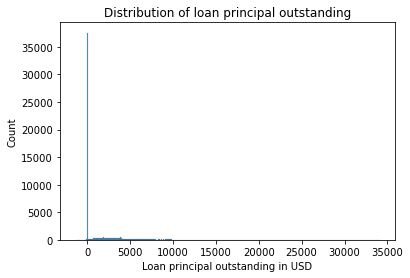

In [306]:
# we will create a new column LoanPrincipalOutstanding

loan_sub_data['LoanPrincipalOutstanding'] = loan_sub_data.LoanOriginalAmount - loan_sub_data.LP_CustomerPrincipalPayments

# We can now check out its distribution
sns.histplot(data=loan_sub_data, x='LoanPrincipalOutstanding',
            bins=get_bin_counts(loan_sub_data.LoanPrincipalOutstanding))

plt.xlabel('Loan principal outstanding in USD')
plt.title('Distribution of loan principal outstanding')

plt.show();

The plot doesn't look so good. Let's plot it on a log scale along the y-axis.

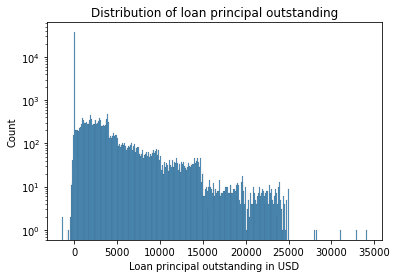

In [307]:
# distribution of the loan principal outstanding on a log scale along the y-axis

sns.histplot(data=loan_sub_data, x='LoanPrincipalOutstanding',
            bins=get_bin_counts(loan_sub_data.LoanPrincipalOutstanding))
            
plt.yscale('log')
plt.xlabel('Loan principal outstanding in USD')
plt.title('Distribution of loan principal outstanding')

plt.show();

The plot reveals some outliers before $0 and after $25,000. Let's take a look at the value counts of our new variable.

In [268]:
loan_sub_data.LoanPrincipalOutstanding.value_counts(dropna=False).sort_index()

-1423.51     1
-1416.48     1
-837.66      1
-692.84      1
-487.19      1
            ..
 28011.80    1
 28277.71    1
 31114.13    1
 32998.22    1
 34102.06    1
Name: LoanPrincipalOutstanding, Length: 19781, dtype: int64

We can see that there are some negative principal outstandings which isn't quite right. Let's explore their original loan amounts and the amount of principal that has been paid. While we are at it, we will also explore their `LP_CustomerPayments` and `LP_InterestandFees` values.

In [276]:
loan_sub_data[loan_sub_data.LoanPrincipalOutstanding < 0][['LoanOriginalAmount', 'LP_CustomerPrincipalPayments',
                                                             'LP_CustomerPayments', 'LP_InterestandFees']]

,LoanOriginalAmount,LP_CustomerPrincipalPayments,LP_CustomerPayments,LP_InterestandFees
132,8600,8618.31,10373.47,1755.16
136,3000,3000.01,3985.53,985.52
156,5500,5500.01,7057.41,1557.40
197,3000,3000.01,3110.04,110.03
241,1100,1100.01,1793.46,693.45
...,...,...,...,...
113806,7500,7500.03,10053.24,2553.21
113818,10000,10007.34,11133.21,1125.87
113825,2550,2556.73,3686.24,1129.51
113843,6001,6001.01,7406.21,1405.20


These are clearly outliers. The principal payments made by the borrowers can't be more than the loan original amount. The additional amounts on the principal payments must have come from the amounts paid for the interest and fees. We will therefore add the additional amounts to their corresponding `LP_InterestandFees` values.

In [308]:
# add excess principal payments to LP_InterestandFees

negative_principal_outstanding = loan_sub_data[loan_sub_data.LoanPrincipalOutstanding<0]
additional_interest_and_fees = negative_principal_outstanding.LoanPrincipalOutstanding * -1

to_replace = negative_principal_outstanding.LP_InterestandFees.values
values = to_replace + additional_interest_and_fees.values

loan_sub_data.LP_InterestandFees.replace(to_replace, values, inplace=True)

# set LP_CustomerPrincipalPayments of these records to be the same as LoanOriginalAmount

to_replace = negative_principal_outstanding.LP_CustomerPrincipalPayments.values
values = negative_principal_outstanding.LoanOriginalAmount.values

loan_sub_data.LP_CustomerPrincipalPayments.replace(to_replace, values, inplace=True)

loan_sub_data[loan_sub_data.LoanPrincipalOutstanding < 0][['LoanOriginalAmount', 'LP_CustomerPrincipalPayments',
                                                             'LP_CustomerPayments', 'LP_InterestandFees']]



,LoanOriginalAmount,LP_CustomerPrincipalPayments,LP_CustomerPayments,LP_InterestandFees
132,8600,8600.0,10373.47,1773.47
136,3000,3000.0,3985.53,985.53
156,5500,5500.0,7057.41,1557.41
197,3000,3000.0,3110.04,110.04
241,1100,1100.0,1793.46,693.46
...,...,...,...,...
113806,7500,7500.0,10053.24,2553.24
113818,10000,10000.0,11133.21,1133.21
113825,2550,2550.0,3686.24,1136.24
113843,6001,6001.0,7406.21,1405.21


Now, we can replace all negative principal outstandings with 0.

In [309]:
to_replace = negative_principal_outstanding.LoanPrincipalOutstanding.values

loan_sub_data.LoanPrincipalOutstanding.replace(to_replace, 0, inplace=True)

loan_sub_data.LoanPrincipalOutstanding.value_counts()

0.00        31588
0.01         2766
0.01          669
0.02          444
0.02          386
            ...  
10100.86        1
5667.92         1
18263.01        1
2278.82         1
2.84            1
Name: LoanPrincipalOutstanding, Length: 18827, dtype: int64

Let's now replot the distribution of the `LoanPrincipalOutstanding`, `LoanOriginalAmount`, `LP_CustomerPrincipalPayments`, and `LP_InterestandFees` variables.

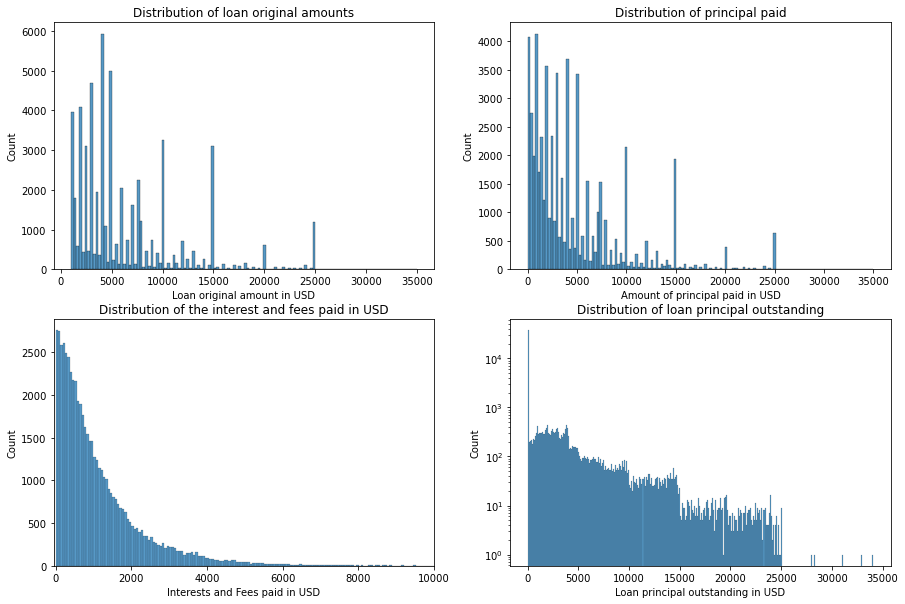

In [314]:
# distribution of the original loan amount

fig, axes = plt.subplots(2,2, figsize=(15,10))

ax1 = sns.histplot(data=loan_sub_data, x='LoanOriginalAmount', 
                  bins=get_bin_counts(loan_sub_data.LoanOriginalAmount), ax=axes[0][0])
                  
ax1.set(xlabel='Loan original amount in USD',
        title='Distribution of loan original amounts')

# distribution of the amount of principal paid

ax2 = sns.histplot(data=loan_sub_data, x='LP_CustomerPrincipalPayments',
                   bins=get_bin_counts(loan_sub_data.LP_CustomerPayments), ax=axes[0][1])

ax2.set(xlabel='Amount of principal paid in USD',
        title='Distribution of principal paid')

# distribution of the interest and fees paid

ax3 = sns.histplot(data=loan_sub_data, x='LP_InterestandFees', 
               bins=get_bin_counts(loan_sub_data.LP_InterestandFees), ax=axes[1][0])

ax3.set_xlim(-50, 10000)

ax3.set(xlabel='Interests and Fees paid in USD',
        title='Distribution of the interest and fees paid in USD')

# distribution of the loan principal outstanding on a log scale along the y-axis

ax4 = sns.histplot(data=loan_sub_data, x='LoanPrincipalOutstanding',
            bins=get_bin_counts(loan_sub_data.LoanPrincipalOutstanding), ax=axes[1][1])
            
ax4.set_yscale('log')
ax4.set_xlabel('Loan principal outstanding in USD')
ax4.set_title('Distribution of loan principal outstanding')

plt.show();

The distribution still looks the same, but with the negative principal outstanding outliers taken care of. The distribution of the loan principal outstanding shows that most borrowers have no principal outstanding which seems to agree with the bar plot of the loan status where we saw that most of the borrowers had completed their loan payments. This suggest a possible relationship between `LoanStatus` and `LoanPrincipalOutstanding`.

##### What is the distribution of the annual percentage rate?

The `BorrowerAPR` variable has some missing values which we can't account for at the moment. Let's see the percentage of null values that it has.

In [315]:
loan_sub_data.BorrowerAPR.isna().sum()/loan_sub_data.BorrowerAPR.shape[0]

0.000435874189274008

As we can see, it is not significant. Therefore, it is okay to replace them with the mean value.

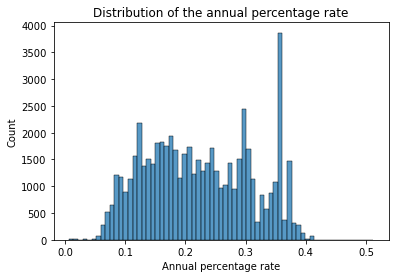

In [316]:
# distribution of the annual percentage rate.
loan_sub_data.BorrowerAPR = loan_sub_data.BorrowerAPR.fillna(loan_sub_data.BorrowerAPR.mean())

ax = sns.histplot(data=loan_sub_data, x='BorrowerAPR', bins=get_bin_counts(loan_sub_data.BorrowerAPR))

ax.set(xlabel='Annual percentage rate',
        title='Distribution of the annual percentage rate')

plt.show();

From the plot, we can see that the distribution of the annual percentage rate is unimodal with the highest peak at around 0.37.

##### What are the distribuions of the total number of prior loans, loan term, and the listing categories?

`Term` and `ListingCategory (numeric)` are both categorical variables so we would explore their distribution on a bar plot. On the other hand, `TotalProsperLoans` is a discrete numeric variable, but because its range of values are relatively small, we can also explore its distribution with a bar plot. This variable also contains null values which means that the borrower had no prior prosper loan. We will replace them with 0.

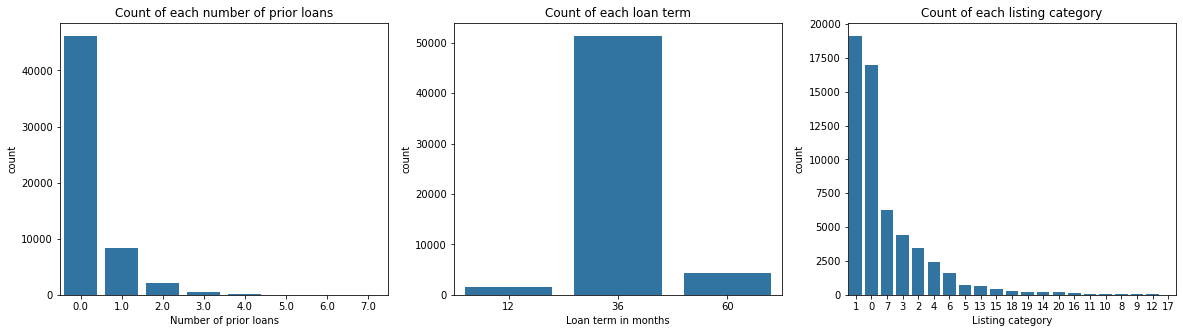

In [317]:
# Distribution of TotalProsperLoans

fig, axes = plt.subplots(1,3, figsize=(20,5))

loan_sub_data.TotalProsperLoans = loan_sub_data.TotalProsperLoans.fillna(0)

ax1 = sns.countplot(data=loan_sub_data, x='TotalProsperLoans', color=sns.color_palette()[0], ax=axes[0], 
                   order=loan_sub_data.TotalProsperLoans.value_counts().index)

ax1.set(xlabel="Number of prior loans",
        title="Count of each number of prior loans")

# distribution of Term

ax2 = sns.countplot(data=loan_sub_data, x='Term', color=sns.color_palette()[0], ax=axes[1])
ax2.set(xlabel="Loan term in months",
        title='Count of each loan term')

# distribution of ListingCategory

ax3 = sns.countplot(data=loan_sub_data, x='ListingCategory (numeric)', color=sns.color_palette()[0], ax=axes[2],
 order=loan_sub_data['ListingCategory (numeric)'].value_counts().index)

ax3.set(xlabel="Listing category",
        title="Count of each listing category")


plt.show();

From the plots, most borrowers had no prior Prosper loans. Also most of their loans were for a 3-year term, and most of them took loans for debt consolidation which is represented as 1 in the `ListCategory (numeric)` variable.

##### What is the distribution of number of days delinquent on the loan?

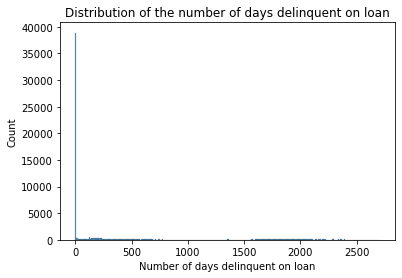

In [318]:
# distribution of LoanCurrentDaysDelinquent

sns.histplot(data=loan_sub_data, x='LoanCurrentDaysDelinquent', bins=get_bin_counts(loan_sub_data.LoanCurrentDaysDelinquent))

plt.xlabel('Number of days delinquent on loan')
plt.title('Distribution of the number of days delinquent on loan')

plt.show();

This doesn't look so good. Let's plot it on a log scale along the y-axis.

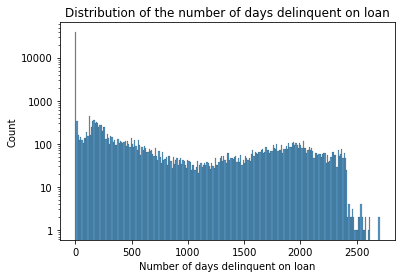

In [319]:
# distribution of LoanCurrentDaysDelinquent

ax = sns.histplot(data=loan_sub_data, x='LoanCurrentDaysDelinquent', 
                 bins=get_bin_counts(loan_sub_data.LoanCurrentDaysDelinquent))

ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(ScalarFormatter())

ax.set_xlabel('Number of days delinquent on loan')
ax.set_title('Distribution of the number of days delinquent on loan')

plt.show();

The distribution is unimodal with the highest peak around 0. This shows that there are more borrowers who were not delinquent on their loans. This seems to agree with our earlier distribution plot of the `LoanStatus` variable where we noticed that most borrowers completed their loans. Therefore, there might be a relationship between both variables which we would explore in the bivariate section.



>**Rubric Tip**: Visualizations should depict the data appropriately so that the plots are easily interpretable. You should choose an appropriate plot type, data encodings, and formatting as needed. The formatting may include setting/adding the title, labels, legend, and comments. Also, do not overplot or incorrectly plot ordinal data.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

Our univariate exploration of our variables of interest shows that most borrowers completed their loans and most of them where not delinquent which suggest a possible relationship between the `LoanStatus` and `LoanCurrentDaysDelinquent` variables. We had to plot the latter on a log scale along the y-axis due to its large range of frequencies in order to make its distribution more obvious. There might also be some relationship between the loan principal outstanding and the loan status.

Most of the borrowers had a 36-month loan term, and most of them didn't have any prior Prosper loan before applying for a loan. Furthermore, most of the borrowers took loans for debt consolidation. The `TotalProsperLoans` variable contains some null values which means that the borrower doesn't have any prior loans. We replaced them with 0 before ploting its distribution. For most borrowers, their annual income falls within the range of $25,000 to $49,999. Also, our univariate exploration shows that most borrowers are employed.

The distribution of the annual percentage rate is unimodal with the highest peak around 0.37. The `BorrowerAPR` variable has some missing values which wasn't accounted for in the data dictionary. Since the proportion of these values is not significant, I decided to replace them with the mean of the variable.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

The plot of the loan principal outstanding revealed some negative outliers which was as a result of having principal payments which where greater than the original loan amount. After examining the `LP_InterestandFees` and `LP_CustomerPayments` values of records with this condition, I concluded that the excess principal payments might have been from interest and fee payments made by the borrower. So, I added them to their `LP_InterestandFees` values and replaced the affected `LP_CustomerPrincipalPayments` values with the values of their original loan amounts and the negative principal outstandings with 0.

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

## Conclusions
>You can write a summary of the main findings and reflect on the steps taken during the data exploration.



> Remove all Tips mentioned above, before you convert this notebook to PDF/HTML


> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML or PDF` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!

